# Malicious Software

This lab focuses on how the malicious software can modifiy our files, hides itself within the host computer, and also spreads across the network to infect other connected devices on that network.

To understand the malware behaviour and to counter it, the following tasks have been caried out in this lab:
- File integrity verification by using cryptographic hashes
- Detection of unauthorized file modifications
- Signature based detection of supicious pattern present in files
- Worm propogation simulation on a network graph

## Initial Setup

In [ ]:
import hashlib
import os
import pandas as pd
import time as time
import re
import random
import networkx as nx

In [ ]:
os.listdir()
!pwd

/content


# Folder Scanning - For File Integrity Basline (Hashing)

This is to create a baseline of cryptographic hashes for files for verification purposes later. And modification to a file's content will result in a different SHA-256 hash. Thus, this will allow detection of file tampering.

In [ ]:
# Initialise list to store baseline hash results
base_results = []

# Loop through all items in the current directory
for i in os.listdir():
    filename = i

    # Skip directories and the CSV files used for storing results
    if os.path.isdir(filename) or filename in ['base_results.csv', 'altered_results.csv']:
        continue

    # Read file bytes safely for hashing
    with open(filename, 'rb') as f:
        data = f.read()

    # Compute SHA-256 hash of the file contents
    hash = hashlib.sha256(data).hexdigest()

    # Record timestamp for when the baseline was created
    timestamp = time.time()

    # Store file name, hash value, and timestamp
    base_results.append([filename, hash, timestamp])

# Convert results into a DataFrame for readability and export
original_data = pd.DataFrame(base_results, columns=['file', 'hash', 'time'])

# Save baseline hashes to disk for future comparison
original_data.to_csv('base_results.csv', index=False)

# Display collected baseline data
print(base_results)

[['example.txt', 'e77ffda360b4c225cb99e82b3902c2fe3a898b2a54425cd53a532c6ff90dd4ee', 1765329043.5586557], ['testing.txt', 'bf98db39a9a0c4f688a4bd73670a6d786fe766398cb4d0c9ec92c6f24ea7801c', 1765329043.5587068], ['ml.lec4.linear_plynomial_models.pdf', '2bdd6b597be9f3d680f91865ea1b3502dfd33e1cac5e4ed116b70cfb888b689d', 1765329043.5659254]]


## Reflection
This builds a baseline state of the folder's content. Even a slight change in any file will result in a completely different hash. This step is crucial for file integrity monitoring.

In [ ]:
original_data.head()

,file,hash,time
0,example.txt,e77ffda360b4c225cb99e82b3902c2fe3a898b2a54425c...,1.765329e+09
1,testing.txt,bf98db39a9a0c4f688a4bd73670a6d786fe766398cb4d0...,1.765329e+09
2,ml.lec4.linear_plynomial_models.pdf,2bdd6b597be9f3d680f91865ea1b3502dfd33e1cac5e4e...,1.765329e+09


# Dectecting Changes To The File

Here in this part we check whether a file has been modified or not since the baseline hash was created and we do this by rehashing the file's content and comparing the results.

In [ ]:
# Initialise list to store updated (current) hash results
altered_results = []

# Loop through all items in the current directory
for i in os.listdir():
    filename = i

    # Skip directories and the baseline/comparison CSV files
    if os.path.isdir(filename) or filename in ['base_results.csv', 'altered_results.csv']:
        continue

    # Read file contents in binary mode to compute hash
    with open(filename, 'rb') as f:
        data = f.read()
        hash = hashlib.sha256(data).hexdigest()  # Current SHA-256 hash
        timestamp = time.time()                 # Time when file was checked

    # Store filename, hash, and timestamp for comparison
    altered_results.append([filename, hash, timestamp])

# Convert results into a DataFrame for readability and persistence
altered_data = pd.DataFrame(altered_results, columns=['file', 'hash', 'time'])

# Save current hashes to disk for comparison with baseline
altered_data.to_csv('altered_results.csv', index=False)

# Show collected data to confirm scan output
print(altered_results)

[['example.txt', 'e77ffda360b4c225cb99e82b3902c2fe3a898b2a54425cd53a532c6ff90dd4ee', 1765329101.1901836], ['testing.txt', 'bf98db39a9a0c4f688a4bd73670a6d786fe766398cb4d0c9ec92c6f24ea7801c', 1765329101.1902378], ['ml.lec4.linear_plynomial_models.pdf', '2bdd6b597be9f3d680f91865ea1b3502dfd33e1cac5e4ed116b70cfb888b689d', 1765329101.1975558]]


## Hash Comparison

In [ ]:
# Only proceed if the baseline list contains entries
if len(base_results) > 0:

    # Iterate through each file entry by index
    for i in range(len(base_results)):

        # Compare baseline hash (index 1) and current hash for the same file
        if base_results[i][1] != altered_results[i][1]:
            # Hash mismatch → file contents have changed
            print(f"File {base_results[i][0]} has been altered...")

        elif base_results[i][1] == altered_results[i][1]:
            # Hash match → file has not been modified
            print(f"File {base_results[i][0]} is safe...")

else:
    # Safety check in case no files were processed
    print("No files to check...")

File example.txt is safe...
File testing.txt is safe...
File ml.lec4.linear_plynomial_models.pdf is safe...


## Reflection
As we can see, this section correctly detects the changes in the tempared file demonstrating us that how hashing actually supports the host-based intrusion detection.

# Signature-Based Scan For Suspicious Patterns

This part deals with searching suspicious code constructs that typical appear in malicious scripts and malwares intended for specific tasks such as dynamic evaluation, encoded payloads and network calls.

## Suspicious Patterns

In [ ]:
# List of suspicious code patterns commonly found in malicious scripts
SIGNATURES = [
    r"eval\(",              # Dynamic code execution
    r"base64\.b64decode",   # Decoding encoded payloads
    r"socket\.connect",     # Network communication (potential C2)
    r"exec\(",              # Executing arbitrary code
    r"import os"            # OS-level operations (file/process manipulation)
]

# Prepare a list to store compiled regex patterns
patterns = []

# Compile each signature into a regular expression for faster matching
for i in SIGNATURES:
    f = (re.compile(i), i)   # Tuple: (compiled_regex, pattern_string)
    patterns.append(f)

# Display loaded and compiled signature patterns
print(patterns)

[(re.compile('eval\\('), 'eval\\('), (re.compile('base64\\.b64decode'), 'base64\\.b64decode'), (re.compile('socket\\.connect'), 'socket\\.connect'), (re.compile('exec\\('), 'exec\\('), (re.compile('import os'), 'import os')]


## Scanning For Above Mentioned Patterns

In [ ]:
# Loop through every item in the current directory
for i in os.listdir():
    filename = i

    # Skip directories — only scan files
    if os.path.isdir(filename):
        continue

    try:
        # Open file in text mode (UTF-8), ignoring decoding errors
        with open(filename, 'r', encoding='utf-8') as f:
            lines = f.readlines()

        # Scan each line of the file
        for i, line in enumerate(lines, start=1):

            # Check line against all compiled suspicious patterns
            for regex, label in patterns:
                if regex.search(line):
                    # Print a match with filename, line number, and pattern
                    print(f"[{filename}] Line {i}: matched '{label}' → {line.strip()}")

    except Exception as e:
        # Handles binary files or unreadable content
        print(f"Error reading file {filename}: {e}")

[example.txt] Line 2: matched 'eval\(' → eval(
[example.txt] Line 3: matched 'base64\.b64decode' → base64.b64decode
[example.txt] Line 4: matched 'socket\.connect' → socket.connect
[example.txt] Line 5: matched 'exec\(' → exec(
[example.txt] Line 6: matched 'import os' → import os
Error reading file ml.lec4.linear_plynomial_models.pdf: 'utf-8' codec can't decode byte 0xe2 in position 10: invalid continuation byte


## Interpretation
The above script correctly flags the multiple suspicious patterns, including eval(, excel(, base64.b64decode, socket.connect, import os.

These are all common primitives used in droppers, backdoors, or encoded payload loaders. And this part clearly demonstrate that how early antivirus softwares used these simple techniques before behavioural detection became dominant.

# Worm Propagation Simulation

The below code demonstrates how worm spread through a network using random selection. And this simulation highlights how progogation speed depends on network topology and aggressiveness of the worm trying to spread infection.

## Network Graph Construction

In [ ]:
# Create an empty NetworkX graph
G = nx.Graph()

# Define edges representing network connections between hosts
edges = [
    ("A", "B"), ("A", "C"),
    ("B", "C"), ("B", "D"),
    ("C", "D"), ("C", "E"),
    ("D", "E"), ("D", "F"),
    ("E", "F"), ("F", "G")
]

# Add all edges to the graph (nodes are created automatically)
G.add_edges_from(edges)

# Display all nodes (hosts) in the network
print(G.nodes)

# Display all edges (connections) in the network
print(G.edges)

['A', 'B', 'C', 'D', 'E', 'F', 'G']
[('A', 'B'), ('A', 'C'), ('B', 'C'), ('B', 'D'), ('C', 'D'), ('C', 'E'), ('D', 'E'), ('D', 'F'), ('E', 'F'), ('F', 'G')]


## Worm Propogation

In [ ]:
def worm_spread_nx(G, start, attempts, steps, seed=None):
    """
    Simulates worm-like propagation across a NetworkX graph.

    Parameters:
        G (networkx.Graph): The network topology (nodes = hosts, edges = connections).
        start (str): Initial infected host ("patient zero").
        attempts (int): Number of infection attempts per infected host per step.
        steps (int): Maximum number of propagation rounds.
        seed (int): Random seed for reproducible results.

    Returns:
        set: All hosts infected by the end of the simulation.
    """

    # Set deterministic randomness (same output for same seed)
    random.seed(seed)

    infected = {start}   # Tracks all infected hosts so far
    wave = {start}       # Hosts that will attempt to infect others in the current step

    # Perform step-by-step propagation
    for step in range(1, steps + 1):

        # Determine new infections for this step
        next_wave = {
            random.choice(list(G.neighbors(node)))   # randomly pick a neighbour to infect
            for node in wave                         # for each newly infected host
            for _ in range(attempts)                 # number of attempts per host
            if list(G.neighbors(node))               # only if the host has neighbours
        } - infected                                 # exclude hosts already infected

        # If the worm fails to infect anything this step
        if not next_wave:
            print(f"{step}: No new infections")
            continue

        # Add new infections to global set
        infected |= next_wave

        # These become the active spreaders for the next round
        wave = next_wave

        # Print propagation summary for this step
        print(f"{step}: New = {sorted(next_wave)} | Total = {len(infected)}")

    return infected

## Execution

In [ ]:
# Runing the worm propagation simulation on the defined network.
# start='A'     → The worm begins at host A (patient zero)
# attempts=2    → Each infected host gets 2 infection attempts per step
# steps=5       → Maximum of 5 propagation rounds
# seed=3        → Fixed random seed ensures reproducible results

worm_spread_nx(G, start='A', attempts=2, steps=5, seed=3)

1: New = ['B'] | Total = 2
2: New = ['C', 'D'] | Total = 4
3: New = ['E', 'F'] | Total = 6
4: No new infections
5: New = ['G'] | Total = 7


{'A', 'B', 'C', 'D', 'E', 'F', 'G'}

## Reflection

As we can see from results, the worm eventually infected all nodes. And the propogation speed accelarated once it reached the denser subgraph (C, D, E, F). Random scanning worms sometimes stall before finding remaining hosts, if newly infected nodes points back to the already infected neighbours, thus replicates the behaivour of worms.

# Countermeasure Design Using Authentication System

To demonstrate defence-in-depth, I integrated my existing authentication system as a practical monitoring prototype. It combines prevention, detection, and mitigation through real security controls rather than simulations.

## Prevention
- Passwords stored with bcrypt + optional pepper
- TOTP-based MFA (prevents password-only compromise)

## Detection
The system logs all abnormal behaviour:
- Invalid username
- Wrong password attempts
- Repeated OTP failures
- Login attempts during lockout
- Successful logins (baseline activity)
These logs act as a host-based intrusion detection mechanism.

## Mitigation
- Account lockout after multiple failed passwords
- OTP retry limit (3 attempts)
- Lockout cooldown to slow brute-force attacks
- Reset of counters on successful authentication

## Login Verification Code

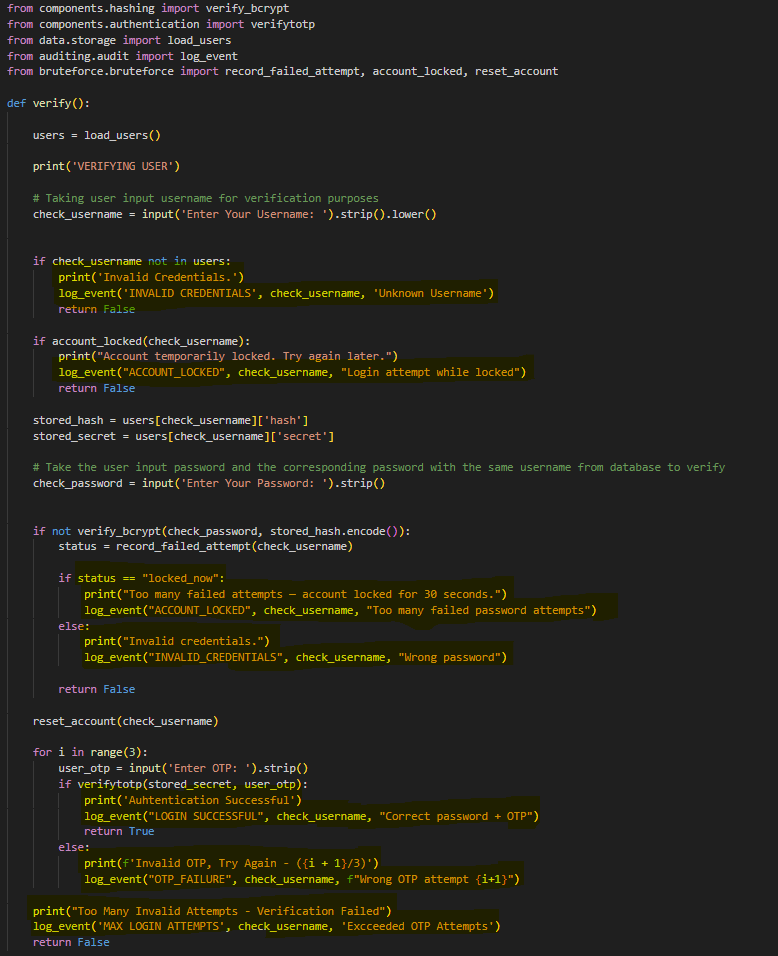

## Login Audits

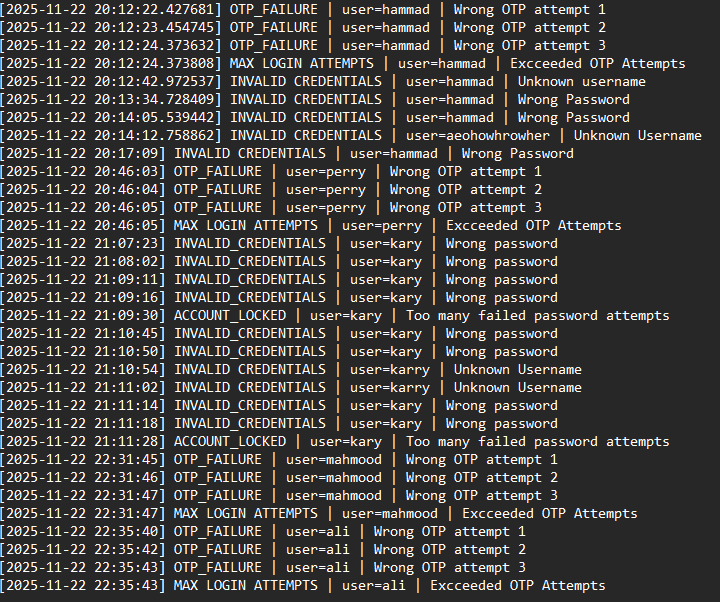

## Reflection

- Human/credential weaknesses often fail first in real-world outbreaks.
- AI can detect anomalies safely by modelling normal behaviour baselines.
- Balancing sensitivity vs false-positives requires threshold tuning and correlating multiple signals.

# Summary

- SHA-256 integrity monitoring provides a reliable way to detect aunothorized chages to a file.
- Baseline vs current hash comparison reveals immediately if data is altered or not
- Signature-based functions works only for known suspicious patterns but cannot defend against obfuscation and polymorphic malwares.
- Worm spread in a network depends on the network's topology and how aggressive the worm is.
- A simple simulation like we used shows us that how quickly worms can compromise a highly connected network.